## MI between descriptors and embeddings

ContextPred
GPT-GNN
GraphMVP
GROVER
AttributeMask
GraphLog
GraphCL
InfoGraph
Not-trained
MolBert
ChemBertMLM-5M
ChemBertMLM-10M
ChemBertMLM-77M
ChemBertMTR-5M
ChemBertMTR-10M
ChemBertMTR-77M
ChemGPT-1.2B
ChemGPT-19M
ChemGPT-4.7M
DenoisingPretrainingPQCMv4
FRAD_QM9
MolR_gat
MolR_gcn
MolR_tag
MoleOOD_OGB_GIN
MoleOOD_OGB_GCN
MoleOOD_OGB_SAGE
ThreeDInfomax


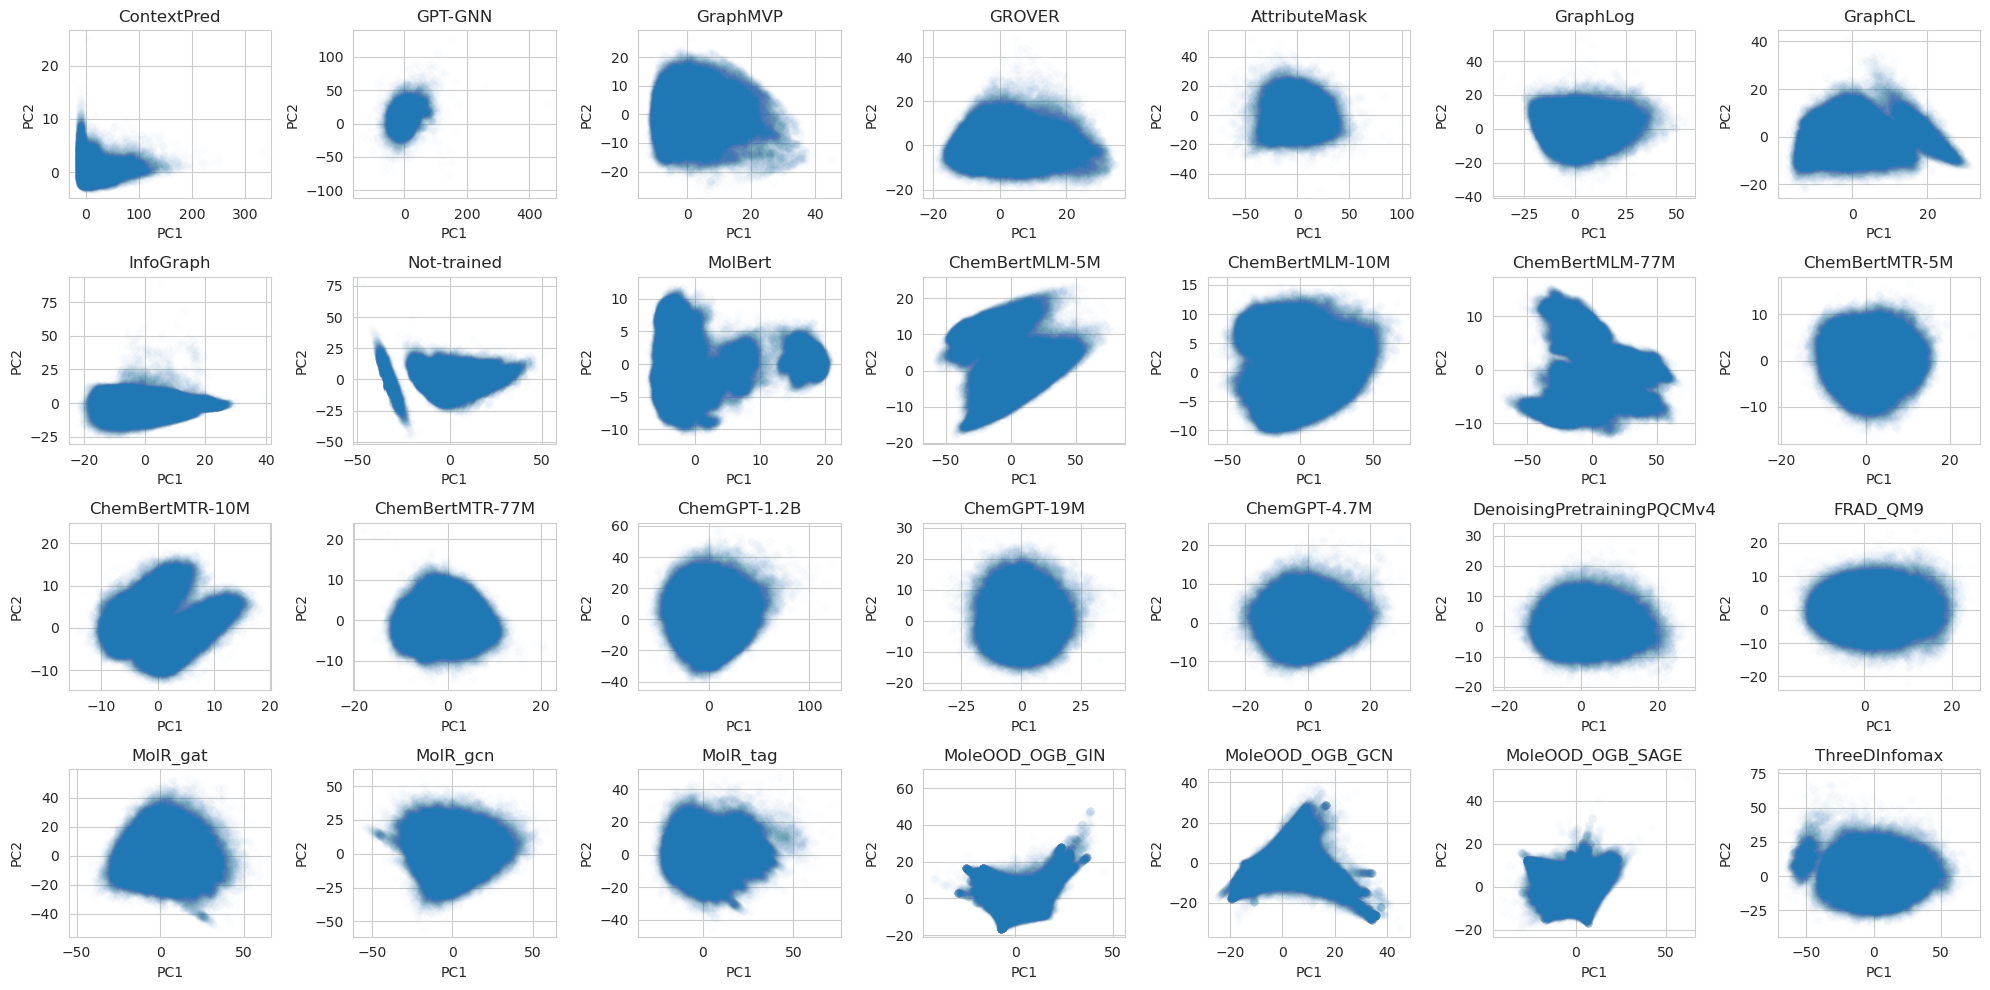

In [5]:
import os
import numpy as np
import pandas as pd

from utils_notebook import get_MI_df, plot_cmap, plot_com, get_ranked_df, LATEX_FIG_PATH,plot_embeddings
import matplotlib.pyplot as plt
import seaborn as sns

DATASET = "ZINC"
COLUMS_SPLIT = "cond_modes"


import json
with open(f"data/ZINC/smiles.json", "r") as f:
    s = json.load(f)

N = len(s)

plot_embeddings(DATASET, figsize=10,alpha=0.01)

In [ ]:
def add_BIC_AIC(df):
    df["n_params_marg"] = df["marg_modes"] * df["Y_dim"] * 2 + df["marg_modes"]
    df["n_params_cond"] =df["ff_hidden_dim"] * ( 2 * df["cond_modes"] * df["Y_dim"] + df["X_dim"] + df["ff_hidden_dim"] * df["ff_layers"] + df["cond_modes"])
    df["n_params_cond_no_ff"] = 2 * df["cond_modes"] * df["Y_dim"] + df["cond_modes"]

    df["BIC_marg"] =np.log(N) * df["n_params_marg"] + 2 * df["I(Y)"] * N
    df["BIC_cond"] =np.log(N) * df["n_params_cond"] + 2 * df["I(X->Y)"] * N
    df["BIC_cond_no_ff"] =np.log(N) * df["n_params_cond_no_ff"] + 2 * df["I(X->Y)"] * N
    df["BIC"] = df["BIC_marg"]  + df["BIC_cond"]
    df["BIC_no_ff"] = df["BIC_marg"]  + df["BIC_cond_no_ff"]

    df["Likelihood_marg"] =  df["I(Y)"] * N
    df["Likelihood_cond"] =  df["I(X->Y)"] * N


    df["AIC_marg"] = 2 * df["n_params_marg"] + 2 * df["Likelihood_marg"]
    df["AIC_cond"] = 2 * df["n_params_cond"] + 2 * df["Likelihood_cond"]
    df["AIC_cond_no_ff"] = 2 * df["n_params_cond_no_ff"] + 2 * df["Likelihood_cond"]
    df["AIC"] = df["AIC_marg"]  + df["AIC_cond"]
    df["AIC_no_ff"] = df["AIC_marg"]  + df["AIC_cond_no_ff"]


    return df



In [7]:
results_dir_list = ["run_1", "run_2", "run_4", "run_8"]
df = get_MI_df(DATASET, results_dir_list)
df = add_BIC_AIC(df)

df[["X", "X_dim"]].drop_duplicates().set_index("X")

100%|██████████| 4/4 [00:00<00:00, 22.94it/s]


NameError: name 'add_BIC_AIC' is not defined

In [8]:
models = df["X"].unique()
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import os
import pandas as pd

df_modes = pd.DataFrame(columns=["model", "inertia", "n_clusters"])


for m in tqdm(models):
    if os.path.exists(f"data/{DATASET}/{m}.npy"):
        emb = np.load(f"data/{DATASET}/{m}.npy", mmap_mode="r")
        for n_clusters in range(1, 17):
            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(emb)
            df_modes = df_modes.append({"model": m, "inertia": kmeans.inertia_, "n_clusters": n_clusters}, ignore_index=True)

  0%|          | 0/28 [00:00<?, ?it/s]/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/tmp/ipykernel_15863/2024229828.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_modes = df_modes.append({"model": m, "inertia": kmeans.inertia_, "n_clusters": n_clusters}, ignore_index=True)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/tmp/ipykernel_15863/2024229828.py:15: FutureWarning: The frame.append method is deprecated 

In [9]:
df_modes["inertia_norm"] = (df_modes.set_index("model").inertia  / df_modes.groupby("model").inertia.min()).reset_index().inertia
df_modes_joined = df_modes.join(df[["X", "X_dim"]].drop_duplicates().set_index("X"), on="model")


<AxesSubplot:xlabel='n_clusters', ylabel='inertia'>

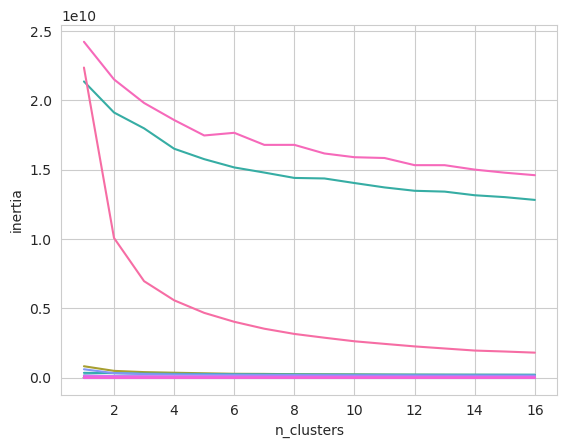

In [10]:
sns.lineplot(data=df_modes, x="n_clusters", y="inertia", hue="model", legend=False)

<AxesSubplot:xlabel='n_clusters', ylabel='inertia_norm'>

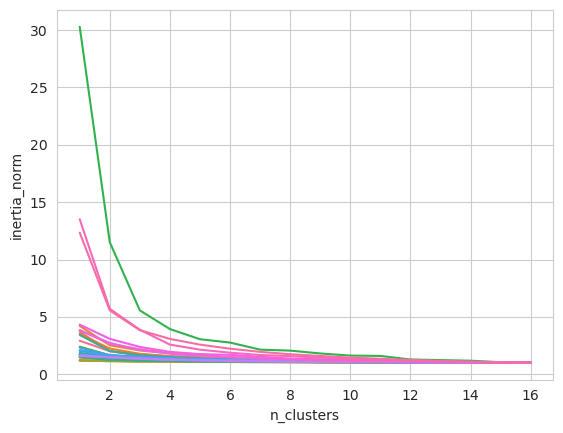

In [11]:
sns.lineplot(data=df_modes, x="n_clusters", y="inertia_norm", hue="model", legend=False)

In [13]:
models = df["X"].unique()
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm
import os
import pandas as pd

df_modes = pd.DataFrame(columns=["model", "d_inertia", "n_clusters"])


for m in tqdm(models):
    if os.path.exists(f"data/{DATASET}/{m}.npy"):
        emb = np.load(f"data/{DATASET}/{m}.npy", mmap_mode="r")
        lastinertia = None
        for n_clusters in range(1, 9):

            kmeans = MiniBatchKMeans(n_clusters=n_clusters, random_state=0).fit(emb)
            if lastinertia is not None:
                df_modes = df_modes.append({"model": m, "d_inertia": lastinertia - kmeans.inertia_, "n_clusters": n_clusters}, ignore_index=True)
            lastinertia = kmeans.inertia_


  0%|          | 0/28 [00:00<?, ?it/s]/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
/tmp/ipykernel_15863/1990431980.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_modes = df_modes.append({"model": m, "d_inertia": lastinertia - kmeans.inertia_, "n_clusters": n_clusters}, ignore_index=True)
/home/philippe/.conda/envs/EMIR/lib/python3.10/site-packages/sklearn/cluster

<AxesSubplot:xlabel='n_clusters', ylabel='d_inertia'>

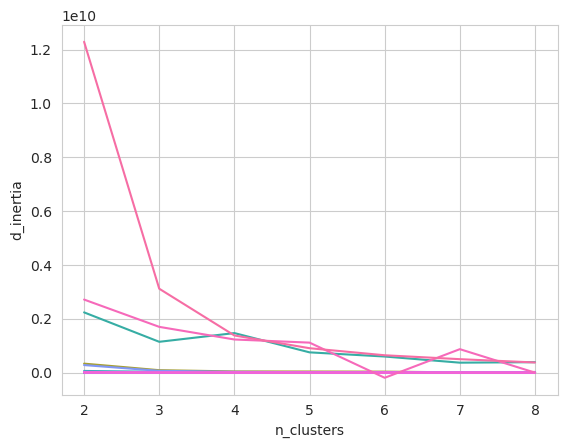

In [16]:
df_modes["d_inertia_norm"] = (df_modes.set_index("model").d_inertia  / df_modes.groupby("model").d_inertia.min().abs()).reset_index().d_inertia


sns.lineplot(data=df_modes, x="n_clusters", y="d_inertia", hue="model", legend=False)

<AxesSubplot:xlabel='n_clusters', ylabel='d_inertia_norm'>

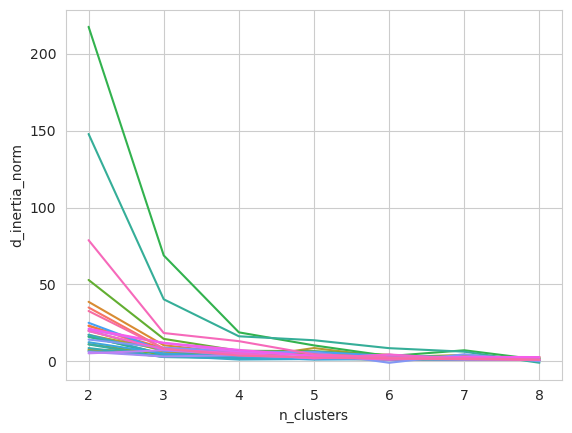

In [15]:
sns.lineplot(data=df_modes, x="n_clusters", y="d_inertia_norm", hue="model", legend=False)